### INSTALLING PACKAGES AND IMPORTING PACKAGES

In [1]:
!pip install tweepy

In [2]:
!pip install nltk

In [3]:
!pip install pillow

In [4]:
!pip install wordcloud

In [5]:
!pip install matplotlib

In [6]:
!pip install textblob

In [7]:
%matplotlib inline

In [8]:
!pip install pandas
!pip install numpy

In [9]:
# https://www.tutorialspoint.com/python_pillow/python_pillow_using_image_module.htm#:~:text=To%20load%20the%20image%2C%20we,Python%20Imaging%20Library%20(PIL).
import string
import re
from PIL import Image
from collections import Counter
import warnings
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import pickle
import json
from pprint import pprint
from wordcloud import WordCloud
# import TwitterCollector
from TwitterCollector import TwitterCollector
# you will use this later to specify the collection time window
from datetime import datetime
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/darianghorbanian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darianghorbanian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Loaded Twitter data to the json by collecting data from the API
# Using that json to create a twitter data file here 

with open('ClimateFinal.json') as json_file:
    recent_tweets=json.load(json_file)

In [11]:
# Reading the data from the csv file containing the author infosrmation
df = pd.read_csv('Author_Info.csv')

In [12]:
# Checking the keys in the twitter data
recent_tweets.keys()

dict_keys(['collection_type', 'collection_timestamp', 'query', 'tweet_cnt', 'tweets'])

In [13]:
# Checking the data structure of the tweets column
print(len(recent_tweets['tweets']))
pprint(recent_tweets['tweets'][1])

10000
{'author_id': '4783834469',
 'context_annotations': [{'domain': {'description': 'A taxonomy view into the '
                                                    'Semantic Core knowledge '
                                                    'graph',
                                     'id': '131',
                                     'name': 'Unified Twitter Taxonomy'},
                          'entity': {'description': 'News',
                                     'id': '1046545033657081857',
                                     'name': 'News'}},
                         {'domain': {'description': 'A taxonomy view into the '
                                                    'Semantic Core knowledge '
                                                    'graph',
                                     'id': '131',
                                     'name': 'Unified Twitter Taxonomy'},
                          'entity': {'description': 'Breaking News',
                            

In [14]:
# Counting the number of unique author Id's in the data 
df.head()
print(len(np.unique(df['author_id'])), 'unique author ID\'s exist in the data')

8258 unique author ID's exist in the data


### (8277 - 8258) = 19 author id's were removed in 2 days, thats is from when we collected the data and when we finished gathering the author information 

In [15]:
# https://www.programiz.com/python-programming/del
# Deleting some columns which we wont be using for our analysis 
del df['Unnamed: 0']
del df['created_at']

In [16]:
# Making a data frame
dftest_author_info = df
dftest_author_info

,author_id,name,username,location,description,followers_count,following_count,tweet_count,listed_count,verified
0,1560493245410357248,chargersfann1978,chargersfann194,NaN,NaN,49,414,3447,0,False
1,4783834469,Y Not Recyclable,RecyclableYnot,"London, England",Planet Earth cannot afford much more pollution...,587,619,3481,6,False
2,5880462,Adam Conover,adamconover,"Los Angeles, CA",Standup comic and television host. Creator & h...,220989,2046,9122,863,True
3,831277785960181764,Renae Lattin,Rdl8192Boyz,NaN,MT born & raised. Independant thinker who love...,116,261,4993,0,False
4,2216079799,Cassandra Pronouns,Indiecornwall,Behind you,Delivering true bad future predictions that no...,1197,4084,48188,9,False
...,...,...,...,...,...,...,...,...,...,...
8253,3372025906,🏀🏆Coach Butler,s_butler2015,"Johannesburg, South Africa",🇺🇸🇿🇦 Involved in ALL Things Basketball💜🏀💛\n\nH...,2582,3516,10812,3,False
8254,2902775914,Liz Wills,mslizwills,United Kingdom,Feminism. Nature. Truth and beauty. Lefty. Fal...,631,1089,3182,3,False
8255,938489490942939138,🏔 Misty Mountain Enjoyer 🏔,FeastOnHisFlesh,Valhalla,Mountain supremacy,151,703,2137,6,False
8256,614299748,Ọya (formerly Duke of Edinburgh Fan) 🇺🇳,fanofprincephil,NaN,Liberal. Was a royalist till 18 Jan. 2020. May...,2072,2247,99686,6,False


In [17]:
# How many unverified and verified authors are present in the data we collected 
total_authors = dftest_author_info['author_id'].count()
unverified_authors = dftest_author_info.groupby(['verified']).count().iloc[0,0]
verified_authors = dftest_author_info.groupby(['verified']).count().iloc[1,0]
perc_unverified_authors = round(unverified_authors*100/total_authors,1)
perc_verified_authors = round(verified_authors*100/total_authors,1)
print(perc_unverified_authors, '% unverified authors')
print(perc_verified_authors, '% verified authors')

93.6 % unverified authors
6.4 % verified authors


In [18]:
# Asked TA Zhang about initializing to None
# Sentiment analysis on the description of authors 
dftest_author_info['auth_polarity'] = None
dftest_author_info['auth_subjectivity'] = None
for i in range(0,len(dftest_author_info)):
    if pd.notnull(dftest_author_info['description'][i]):
        dftest_author_info['auth_polarity'][i] = TextBlob(dftest_author_info['description'][i]).sentiment.polarity
        dftest_author_info['auth_subjectivity'][i] = TextBlob(dftest_author_info['description'][i]).sentiment.subjectivity
    else:
        dftest_author_info['auth_polarity'][i] = 0
        dftest_author_info['auth_subjectivity'][i] = 0

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/2331423236.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest_author_info['auth_polarity'][i] = 0
/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/2331423236.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest_author_info['auth_subjectivity'][i] = 0
/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/2331423236.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [19]:
# Converting both the columns to floattype 
dftest_author_info['auth_polarity'] = dftest_author_info['auth_polarity'].astype(float)
dftest_author_info['auth_subjectivity'] = dftest_author_info['auth_subjectivity'].astype(float)

### PART B [PRELIMINARY ANALYSIS]

### Ten most popular words with and without stop words

In [20]:
words = []
for i in range(0,len(recent_tweets['tweets'])):
    words.extend(recent_tweets['tweets'][i]['text'].split())

# Convert all to lower case
for i in range(0, len(words)):
    words[i] = words[i].lower()

for i in range(0,len(words)):
    words[i] = words[i].replace('.', '')
    words[i] = words[i].replace(',', '')
    words[i] = words[i].replace('?','')
    words[i] = words[i].replace('https:','')
    words[i] = words[i].replace('//tco/','')

In [21]:
c1 = Counter(words)
c1.most_common(10)

[('the', 11405),
 ('climate', 9846),
 ('change', 8887),
 ('to', 7789),
 ('and', 6063),
 ('of', 5441),
 ('is', 5262),
 ('a', 4683),
 ('in', 3690),
 ('for', 2647)]

In [22]:
# https://pythonspot.com/nltk-stop-words/
# import stopwords from nltk package
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
# adding words to the stopwords list 
list = ['The', '&', '&amp', '&amp;', 'like', 'We', 'You', 'And', 'This', 'us', 'know', 'would', 'make', 'think', 'If', 'It', 'get', 'They', 'change?', 'What', 'going',"it’s", 'want', 
        'even', 'made', 'look', 'may', 'via', 'anything', 'take', 'said', 'yet', 'guy', 'tell', 'please', 'everything', 'say', 'yes', 
              'getting', 'already', "don't", "didn't", 'really', 'got', "doesn't", 're']
for i in list:
    stopwords.append(i)
print(stopwords, sep="\n")

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
wordcloud = [] # our accumulator list

for w in words:
    if w not in stopwords and len(w) > 1:
        wordcloud.append(w)
        
c2 = Counter(wordcloud)
c2.most_common(10)

[('climate', 9846),
 ('change', 8887),
 ('people', 885),
 ('global', 547),
 ('world', 469),
 ('one', 455),
 ('hurricane', 433),
 ('real', 396),
 ('need', 370),
 ('years', 367)]

In [25]:
# ten most popular hashtags (#hashtag)?

words3 = [] # our accumulator list

for w in words:
    if '#' in w and len(w) > 1:
        words3.append(w)

c3 = Counter(words3)
c3.most_common(10)

# FreyaTheWalrus?

[('#climatechange', 206),
 ('#climate', 156),
 ('#freya', 55),
 ('#freyathewalrus', 55),
 ('#climatecrisis', 51),
 ('#hurricaneian', 45),
 ('#climateemergency', 44),
 ('#climateaction', 42),
 ('#cop27', 32),
 ('#climatescam', 27)]

In [26]:
# ten most frequently mentioned usernames (@username)

words4 = [] # our accumulator list

for w in words:
    if '@' in w and len(w) > 1:
        words4.append(w)

c4 = Counter(words4)
c4.most_common(10)

[('@foxnews', 88),
 ('@tomfitton', 79),
 ('@elonmusk', 69),
 ('@govrondesantis', 62),
 ('@stevenbeschloss', 59),
 ('@timrunshismouth', 53),
 ('@potus', 53),
 ('@petersweden7', 53),
 ('@jojofromjerz', 48),
 ('@totalenergies', 48)]

In [27]:
# Checking...
recent_tweets['tweets'][0]['source']

'Twitter for Android'

In [28]:
sources = [] # our accumulator list

for i in range(0, len(recent_tweets['tweets'])):
    sources.append(recent_tweets['tweets'][i]['source'])

c5 = Counter(sources)
c5.most_common(3)

[('Twitter Web App', 3909),
 ('Twitter for iPhone', 2530),
 ('Twitter for Android', 1966)]

In [29]:
dftest_author_info.head()

,author_id,name,username,location,description,followers_count,following_count,tweet_count,listed_count,verified,auth_polarity,auth_subjectivity
0,1560493245410357248,chargersfann1978,chargersfann194,NaN,NaN,49,414,3447,0,False,0.00000,0.000000
1,4783834469,Y Not Recyclable,RecyclableYnot,"London, England",Planet Earth cannot afford much more pollution...,587,619,3481,6,False,0.25000,0.250000
2,5880462,Adam Conover,adamconover,"Los Angeles, CA",Standup comic and television host. Creator & h...,220989,2046,9122,863,True,0.03125,0.350000
3,831277785960181764,Renae Lattin,Rdl8192Boyz,NaN,MT born & raised. Independant thinker who love...,116,261,4993,0,False,0.00000,0.000000
4,2216079799,Cassandra Pronouns,Indiecornwall,Behind you,Delivering true bad future predictions that no...,1197,4084,48188,9,False,-0.16250,0.460417


In [30]:
# Creating a data frame 'twitter_data' from recent tweets
twitter_data = pd.DataFrame(recent_tweets['tweets'])

In [31]:
twitter_data.head()

,source,entities,created_at,lang,text,context_annotations,edit_history_tweet_ids,possibly_sensitive,in_reply_to_user_id,public_metrics,id,referenced_tweets,author_id,attachments,geo
0,Twitter for Android,"{'annotations': [{'start': 93, 'end': 102, 'pr...",2022-10-03T23:06:12.000Z,en,@blakesinsight @justmyowndrama @TinaKotek @Mot...,"[{'domain': {'id': '131', 'name': 'Unified Twi...",[1577072554820632576],False,2980643382,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072554820632576,"[{'type': 'replied_to', 'id': '157701416307932...",1560493245410357248,NaN,NaN
1,WordPress.com,"{'urls': [{'start': 84, 'end': 107, 'url': 'ht...",2022-10-03T23:06:12.000Z,en,Breaking News! Hurricanes are increasing! Is c...,"[{'domain': {'id': '131', 'name': 'Unified Twi...",[1577072553566380047],False,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072553566380047,NaN,4783834469,NaN,NaN
2,Twitter Web App,"{'urls': [{'start': 277, 'end': 300, 'url': 'h...",2022-10-03T23:06:07.000Z,en,If you live on LA's Westside and you want to s...,"[{'domain': {'id': '131', 'name': 'Unified Twi...",[1577072534700163072],False,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072534700163072,"[{'type': 'quoted', 'id': '1577013452551266305'}]",5880462,NaN,NaN
3,Twitter Web App,"{'mentions': [{'start': 0, 'end': 13, 'usernam...",2022-10-03T23:06:03.000Z,en,@JudiciaryGOP Reality check here: U @GOP prete...,"[{'domain': {'id': '123', 'name': 'Ongoing New...",[1577072517717848064],False,1131917492,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072517717848064,"[{'type': 'replied_to', 'id': '157693406982035...",831277785960181764,NaN,NaN
4,Twitter Web App,"{'mentions': [{'start': 0, 'end': 6, 'username...",2022-10-03T23:06:01.000Z,en,@UlDel @cameraZoe @medialens @JustStop_Oil @Ge...,"[{'domain': {'id': '10', 'name': 'Person', 'de...",[1577072508301611009],False,422690345,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072508301611009,"[{'type': 'replied_to', 'id': '157686594479812...",2216079799,NaN,NaN


In [32]:
twitter_data["created_at"] = pd.to_datetime(twitter_data["created_at"])

In [33]:
twitter_data['day'] = pd.DatetimeIndex(twitter_data['created_at']).day
twitter_data['hour'] = pd.DatetimeIndex(twitter_data['created_at']).hour
twitter_data['minute'] = pd.DatetimeIndex(twitter_data['created_at']).minute

In [34]:
tweet_by_min = pd.DataFrame(twitter_data.groupby(['minute']).count()['id'])
tweet_by_min['minute'] = tweet_by_min.index

In [35]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
# https://stackoverflow.com/questions/18022845/pandas-index-column-title-or-name
tweet_by_min.rename(columns={"id":"count"})
tweet_by_min.index.names = ['index']

In [36]:
tweet_by_min

,id,minute
index,,
0,285,0
1,188,1
2,175,2
3,175,3
4,187,4
5,169,5
6,139,6
7,138,7
8,137,8


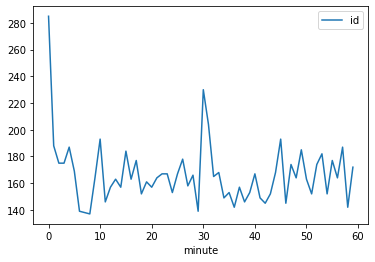

In [37]:
# https://matplotlib.org/stable/tutorials/introductory/pyplot.html
tweet_by_min.plot(x="minute", y="id", kind="line")
plt.show()

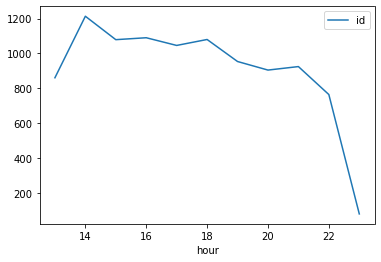

In [38]:
tweet_by_hour = pd.DataFrame(twitter_data.groupby(['hour']).count()['id'])
tweet_by_hour['hour'] = tweet_by_hour.index
tweet_by_hour.rename(columns={"id":"count"})
tweet_by_hour.index.names = ['index']
tweet_by_hour.plot(x="hour", y="id", kind="line")
plt.show()

In [39]:
twitter_data['hour'].unique()

array([23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13])

In [40]:
# Which are the three most influential tweets?
twitter_data['influence_score'] = None
for i in range(0, len(twitter_data)):
    twitter_data['influence_score'][i] = twitter_data['public_metrics'][i]['retweet_count'] + twitter_data['public_metrics'][i]['reply_count'] + twitter_data['public_metrics'][i]['like_count'] + twitter_data['public_metrics'][i]['quote_count']

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/1182290617.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_data['influence_score'][i] = twitter_data['public_metrics'][i]['retweet_count'] + twitter_data['public_metrics'][i]['reply_count'] + twitter_data['public_metrics'][i]['like_count'] + twitter_data['public_metrics'][i]['quote_count']


In [41]:
twitter_data.head()

,source,entities,created_at,lang,text,context_annotations,edit_history_tweet_ids,possibly_sensitive,in_reply_to_user_id,public_metrics,id,referenced_tweets,author_id,attachments,geo,day,hour,minute,influence_score
0,Twitter for Android,"{'annotations': [{'start': 93, 'end': 102, 'pr...",2022-10-03 23:06:12+00:00,en,@blakesinsight @justmyowndrama @TinaKotek @Mot...,"[{'domain': {'id': '131', 'name': 'Unified Twi...",[1577072554820632576],False,2980643382,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072554820632576,"[{'type': 'replied_to', 'id': '157701416307932...",1560493245410357248,NaN,NaN,3,23,6,0
1,WordPress.com,"{'urls': [{'start': 84, 'end': 107, 'url': 'ht...",2022-10-03 23:06:12+00:00,en,Breaking News! Hurricanes are increasing! Is c...,"[{'domain': {'id': '131', 'name': 'Unified Twi...",[1577072553566380047],False,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072553566380047,NaN,4783834469,NaN,NaN,3,23,6,0
2,Twitter Web App,"{'urls': [{'start': 277, 'end': 300, 'url': 'h...",2022-10-03 23:06:07+00:00,en,If you live on LA's Westside and you want to s...,"[{'domain': {'id': '131', 'name': 'Unified Twi...",[1577072534700163072],False,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072534700163072,"[{'type': 'quoted', 'id': '1577013452551266305'}]",5880462,NaN,NaN,3,23,6,3
3,Twitter Web App,"{'mentions': [{'start': 0, 'end': 13, 'usernam...",2022-10-03 23:06:03+00:00,en,@JudiciaryGOP Reality check here: U @GOP prete...,"[{'domain': {'id': '123', 'name': 'Ongoing New...",[1577072517717848064],False,1131917492,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072517717848064,"[{'type': 'replied_to', 'id': '157693406982035...",831277785960181764,NaN,NaN,3,23,6,0
4,Twitter Web App,"{'mentions': [{'start': 0, 'end': 6, 'username...",2022-10-03 23:06:01+00:00,en,@UlDel @cameraZoe @medialens @JustStop_Oil @Ge...,"[{'domain': {'id': '10', 'name': 'Person', 'de...",[1577072508301611009],False,422690345,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1577072508301611009,"[{'type': 'replied_to', 'id': '157686594479812...",2216079799,NaN,NaN,3,23,6,0


In [42]:
# Top 3 tweets based on Influence score
# try and find the author if possible
twitter_data.sort_values('influence_score', ascending = False).head(3)['text']

7314    So I was the only WH pool print reporter in th...
9106    The same people telling you to stop climate ch...
7040    .@KwasiKwarteng has gall to say he has sound p...
Name: text, dtype: object

In [43]:
# three most vocal authors in the data based on the number of tweets per author
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html
c4 = Counter(twitter_data['author_id'])
top_vocal=[]
for i in range (0,3):
    top_vocal.append(int(c4.most_common(3)[i][0]))

dftest_author_info[dftest_author_info['author_id'].isin(top_vocal)]['name']

3944             Peter Paul
5767     leave world better
7031    Seeking Truth&Facts
Name: name, dtype: object

In [44]:
# Who are the three most influential authors
dftest_author_info
dftest_author_info['influence_author'] = None
for i in range(0, len(dftest_author_info)):
    dftest_author_info['influence_author'][i] = dftest_author_info['followers_count'][i] + dftest_author_info['following_count'][i] + dftest_author_info['tweet_count'][i] + dftest_author_info['listed_count'][i]

dftest_author_info.sort_values('influence_author', ascending = False).head(3)['name']

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/1524667991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest_author_info['influence_author'][i] = dftest_author_info['followers_count'][i] + dftest_author_info['following_count'][i] + dftest_author_info['tweet_count'][i] + dftest_author_info['listed_count'][i]


5756              CNN
2412    The Economist
4489          Reuters
Name: name, dtype: object

## Wordcloud Analysis

In [45]:
# https://www.w3schools.com/python/ref_string_join.asp
wordcloud1 = ' '.join(wordcloud)

In [46]:
wordcloud1

'@blakesinsight @justmyowndrama @tinakotek @mothersbistro piss wowed shitbag tina kotek talks abortion lgtbq climate change turning voters smug arrogant liberal attitude calling white supremacists cause agree wacko extreme liberal ideas breaking news! hurricanes increasing! climate change cause! sayin\' h9uwkngnyw live la\'s westside see change city city fights climate change protects vulnerable communities tackles housing homelessness crisis ways actually work support @westsidedarling he\'s real deal xc9ijzdref @judiciarygop reality check here: @gop pretend covid wasn\'t/isn\'t thing admit effects climate change any1 common sense explains grocery prices safety=purging @gop injected hate in2 society maybe sit stfu! @uldel @camerazoe @medialens @juststop_oil @georgemonbiot @chrisgpackham @gretathunberg many years i\'ve seen climate change action parcel passed around we\'ve act act #melting #ice links climate change melting ice #climate #change #rising_water #antarctica #glacier #greenla

In [47]:
wordcloud1 = wordcloud1.replace("don’t", "")
wordcloud1 = wordcloud1.replace("i’m", "")
wordcloud1 = wordcloud1.replace("!", "")
wordcloud1 = wordcloud1.replace("\'", "")
wordcloud1 = wordcloud1.replace("didn’t", "")
wordcloud1 = wordcloud1.replace(" let ", "")
wordcloud1 = wordcloud1.replace(" go ", "")
wordcloud1 = wordcloud1.replace(" etc ", "")
wordcloud1 = wordcloud1.replace(" well ", "")
wordcloud1 = wordcloud1.replace(" still ", "")
wordcloud1 = wordcloud1.replace(" today ", "")
wordcloud1 = wordcloud1.replace(" day ", "")
wordcloud1 = wordcloud1.replace(" must ", "")
wordcloud1 = wordcloud1.replace(":", " ")
wordcloud1 = wordcloud1.replace(" od ", " ")
wordcloud1 = wordcloud1.replace('"', '')
wordcloud1 = wordcloud1.replace('"climate', 'climate')
wordcloud1 = wordcloud1.replace(" im ", " ")
wordcloud1 = wordcloud1.replace(" re ", "")
wordcloud1 = wordcloud1.replace(" s ", "")
wordcloud1 = wordcloud1.replace(" S ", "")
wordcloud1 = wordcloud1.replace("change”", "change")
wordcloud1 = wordcloud1.replace(" we ", "")

In [48]:
wordcloud1
wordcloudtest = wordcloud1.split() # our accumulator list
wordccounter = Counter(wordcloudtest)
list1 = wordccounter.most_common(130)
list1

[('climate', 10066),
 ('change', 9392),
 ('people', 872),
 ('global', 564),
 ('world', 500),
 ('one', 447),
 ('hurricane', 438),
 ('real', 414),
 ('science', 410),
 ('years', 381),
 ('need', 365),
 ('new', 359),
 ('energy', 350),
 ('time', 315),
 ('believe', 313),
 ('weather', 297),
 ('help', 289),
 ('also', 289),
 ('hurricanes', 282),
 ('money', 268),
 ('right', 268),
 ('warming', 266),
 ('see', 265),
 ('much', 264),
 ('stop', 263),
 ('ian', 262),
 ('could', 243),
 ('health', 238),
 ('nothing', 237),
 ('way', 236),
 ('florida', 236),
 ('carbon', 231),
 ('many', 229),
 ('work', 223),
 ('republicans', 220),
 ('use', 218),
 ('bill', 216),
 ('fight', 214),
 ('good', 214),
 ('due', 210),
 ('#climatechange', 209),
 ('thing', 208),
 ('planet', 208),
 ('problem', 205),
 ('scientists', 202),
 ('man', 200),
 ('human', 200),
 ('last', 200),
 ('important', 196),
 ('hoax', 196),
 ('effects', 190),
 ('government', 190),
 ('war', 189),
 ('water', 188),
 ('says', 183),
 ('big', 182),
 ('covid', 179),

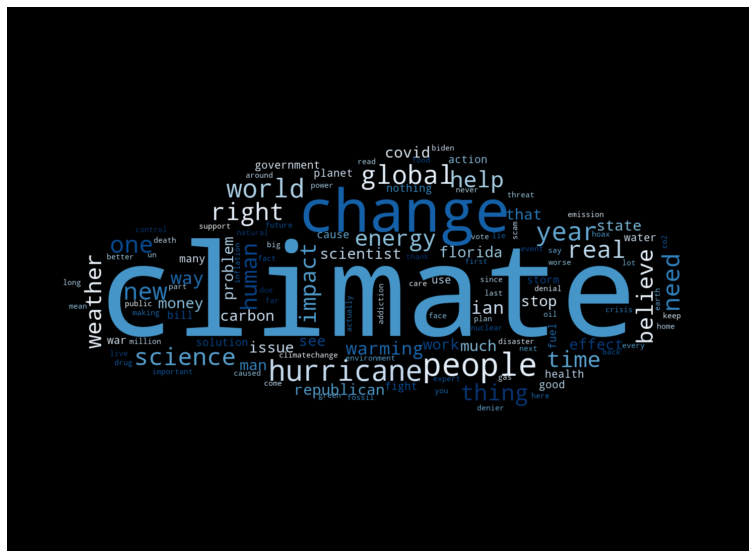

In [51]:
# https://www.tutorialspoint.com/python_pillow/python_pillow_using_image_module.htm#:~:text=To%20load%20the%20image%2C%20we,Python%20Imaging%20Library%20(PIL).
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
image = np.array(Image.open(r'Cloud2.jpeg'))
word_cloud = WordCloud(max_words = 125, max_font_size = 100, collocations = False, 
                       scale =3, mask = image,
                      colormap = 'Blues',
                      stopwords=['re', 'S', 't', 'we', 'could', 'also']).generate(wordcloud1) # note that text is a string, not a list

# Display the generated image:
plt.figure(figsize=(20,10)) # set up figure size
plt.imshow(word_cloud, interpolation = 'bilinear') # word cloud image show
plt.axis("off") # turn on axis
plt.savefig('my_word_cloud.png') # save as PNG file
plt.savefig('my_word_cloud.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook

### Sentiment Analysis

In [52]:
TextBlob(twitter_data['text'][0]).sentiment.polarity

-0.0625

In [53]:
twitter_data['polarity'] = None
twitter_data['subjectivity'] = None
for i in range(0,len(twitter_data)):
    twitter_data['polarity'][i] = TextBlob(twitter_data['text'][i]).sentiment.polarity
    twitter_data['subjectivity'][i] = TextBlob(twitter_data['text'][i]).sentiment.subjectivity

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/1996293784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_data['polarity'][i] = TextBlob(twitter_data['text'][i]).sentiment.polarity
/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/1996293784.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_data['subjectivity'][i] = TextBlob(twitter_data['text'][i]).sentiment.subjectivity


In [54]:
# What are the average polarity and subjectivity scores
print('Average Polarity score across the data is:', round(twitter_data['polarity'].mean(),2))
print('Average Subjectivity score across the data is:', round(twitter_data['subjectivity'].mean(),2))

Average Polarity score across the data is: 0.07
Average Subjectivity score across the data is: 0.39


In [60]:
# Top 3 texts based on highest polarity
x1 = twitter_data.sort_values('polarity', ascending=False).head(3)['text']
print('Polarity Score: ', twitter_data.sort_values('polarity', ascending=False)['polarity'].iloc[0,], '\n',x1.iloc[0,])
print('Polarity Score: ', twitter_data.sort_values('polarity', ascending=False)['polarity'].iloc[1,], '\n',x1.iloc[1,])
print('Polarity Score: ', twitter_data.sort_values('polarity', ascending=False)['polarity'].iloc[2,], '\n',x1.iloc[2,])

Polarity Score:  1.0 
 @BitcoinLovesAll @Reuters Coming from a bitcoin &amp; climate change denier clown spamming garbage: priceless.
Polarity Score:  1.0 
 @mattgaetz Dear FL, your elected reps have done nothing to prepare for climate change and are now asking for a handout. While we are very happy to help our fellow US citizens during a crisis, please address the long-term sustainability of inhabiting a sinking ship.
Polarity Score:  1.0 
 @WSandsin @GovRonDeSantis @CaseyDeSantis You need to focus on something besides "climate change" (Democrats BS) and the ins. companies are going backrupt is why they are gone. Ron is the best Governor in the United States.


In [61]:
# Top 3 texts based on lowest polarity
x2 = twitter_data.sort_values('polarity', ascending=True).head(3)['text']
print('Polarity Score: ', twitter_data.sort_values('polarity', ascending=True)['polarity'].iloc[0,], '\n',x2.iloc[0,])
print('Polarity Score: ', twitter_data.sort_values('polarity', ascending=True)['polarity'].iloc[1,], '\n',x2.iloc[1,])
print('Polarity Score: ', twitter_data.sort_values('polarity', ascending=True)['polarity'].iloc[2,], '\n',x2.iloc[2,])

Polarity Score:  -1.0 
 @KTFministry Notice that all the discussion is about climate change &amp; man's use of oil but SIN IS never mentioned. The Bible shows us that evil was on the earth and God destroyed Sodom &amp; Gomorrah. Sulfur balls are still found there but there is no life even to this day in that part of world.
Polarity Score:  -1.0 
 You've all been brainwashed into thinking climate change is terrifying and nuclear war with Russia isn't
Polarity Score:  -1.0 
 For the Brainwashed Morons fretting about Non-existent Climate Change. Read this and shut the hell up!
https://t.co/52XShKuhew


In [62]:
# Top 3 texts based on highest subjectivity
x3 = twitter_data.sort_values('subjectivity', ascending=False).head(3)['text']
print('Subjectivity Score: ', twitter_data.sort_values('subjectivity', ascending=False)['subjectivity'].iloc[0,], '\n',x3.iloc[0,])
print('Subjectivity Score: ', twitter_data.sort_values('subjectivity', ascending=False)['subjectivity'].iloc[1,], '\n',x3.iloc[1,])
print('Subjectivity Score: ', twitter_data.sort_values('subjectivity', ascending=False)['subjectivity'].iloc[2,], '\n',x3.iloc[2,])

Subjectivity Score:  1.0 
 @RemiParmentier @COP27P @Greenpeace @UNFCCC That is a weird message! Who enjoys climate change!
Subjectivity Score:  1.0 
 "Or could the Academy fight inflation and climate change simultaneously, awarding William Volmann in a desperate attempt to stop him from publishing six 800-page books a year?" https://t.co/zTtee82HGd
Subjectivity Score:  1.0 
 @tribelaw If they gut the CWA it will have profound impacts on climate change


In [63]:
#Top 3 text based on lowest subjectivity
x4 = twitter_data.sort_values('subjectivity', ascending=True).head(3)['text']
print('Subjectivity Score: ', twitter_data.sort_values('subjectivity', ascending=True)['subjectivity'].iloc[0,], '\n',x4.iloc[0,])
print('Subjectivity Score: ', twitter_data.sort_values('subjectivity', ascending=True)['subjectivity'].iloc[1,], '\n',x4.iloc[1,])
print('Subjectivity Score: ', twitter_data.sort_values('subjectivity', ascending=True)['subjectivity'].iloc[2,], '\n',x4.iloc[2,])

Subjectivity Score:  0.0 
 @TomFitton They changed it from "warming" to "climate change" for a reason!  Don't be so gullible people! 😩 https://t.co/ApeTTOiVcg
Subjectivity Score:  0.0 
 @mattgaetz Why don’t you start trying to reverse the effects of climate change and lessen the severity of weather events before we put people in these dire situations?
Subjectivity Score:  0.0 
 @SnowScottish @EJ_Nofear87 @RoyallyBlunt However neither he or Travelyst are credentialed for COP27.  Read:  🎩

https://t.co/okv7OUWvuD


plotting:

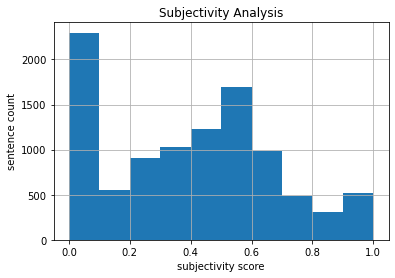

In [67]:
plt.hist(twitter_data['subjectivity'], bins=10) #, normed=1, alpha=0.75)
plt.title("Subjectivity Analysis")
plt.xlabel('subjectivity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('subjectivity.pdf')
plt.show()

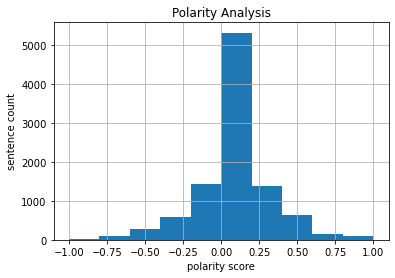

In [68]:
plt.hist(twitter_data['polarity'], bins=10) #, normed=1, alpha=0.75)
plt.title("Polarity Analysis")
plt.xlabel('polarity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('subjectivity.pdf')
plt.show()

In [69]:
twitter_data['author_id'] = twitter_data['author_id'].astype(float)

In [70]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
total_data = twitter_data.merge(dftest_author_info, how="left", on=['author_id'])

In [71]:
total_data.shape

(10000, 33)

In [72]:
total_data.columns

Index(['source', 'entities', 'created_at', 'lang', 'text',
       'context_annotations', 'edit_history_tweet_ids', 'possibly_sensitive',
       'in_reply_to_user_id', 'public_metrics', 'id', 'referenced_tweets',
       'author_id', 'attachments', 'geo', 'day', 'hour', 'minute',
       'influence_score', 'polarity', 'subjectivity', 'name', 'username',
       'location', 'description', 'followers_count', 'following_count',
       'tweet_count', 'listed_count', 'verified', 'auth_polarity',
       'auth_subjectivity', 'influence_author'],
      dtype='object')

In [73]:
# Attachment analysis
total_data['items_in_attachment'] = None
for i in range(0, len(total_data)):
    if pd.isna(total_data['attachments'][i]):
        total_data['items_in_attachment'][i] = 0
    else:
        total_data['items_in_attachment'][i] = len(pd.DataFrame(total_data['attachments'][i]))

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/568080128.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['items_in_attachment'][i] = 0
/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/568080128.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['items_in_attachment'][i] = len(pd.DataFrame(total_data['attachments'][i]))


In [74]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.notna.html
total_attachments = total_data[pd.notna(total_data['attachments'])]['attachments'].count()
total_items = total_data['items_in_attachment'].sum()
print('The total number of attachments in the data are:', total_attachments)
print('The total number of items in the attachments are:', total_items)

The total number of attachments in the data are: 1262
The total number of items in the attachments are: 1594


### Analyzing based on verified and unverified authors:

In [89]:
# SentiScore for verified/unverified users based on the description they had
total_data.groupby('verified')['auth_polarity', 'auth_subjectivity'].mean()

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/2943557930.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_data.groupby('verified')['auth_polarity', 'auth_subjectivity'].mean()


,auth_polarity,auth_subjectivity
verified,,
False,0.076816,0.251823
True,0.119494,0.277585


In [94]:
# SentiScore for verified/unverified authors based on their tweets for climate change:
total_data.groupby('verified')['polarity','subjectivity'].mean()

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/3621302889.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_data.groupby('verified')['polarity','subjectivity'].mean()


,polarity,subjectivity
verified,,
False,0.073826,0.394526
True,0.105565,0.387753


In [95]:
# Top 3 texts from verified and unverified users based on highest polarity
print('From Verified Authors:', '\n')
print(total_data[total_data['verified'] == True].sort_values('polarity', ascending=False).head(3)['text'], '\n')
print('\n')
print('From Unverified Authors:', '\n')
print(total_data[total_data['verified'] == False].sort_values('polarity', ascending=False).head(3)['text'])

From Verified Authors: 

9689    Chile's Cape Horn, the area at the tip of Sout...
6606    In this great article from @UMengineering, lea...
9511    WATCH: Chile's Cape Horn, the area at the tip ...
Name: text, dtype: object 



From Unverified Authors: 

1939    @VA_GOP Its a wake up call for ALL climate cha...
1659    @hoshistiger_13 these are some good ones i did...
9078    Highlighting the intersectionality of @Climate...
Name: text, dtype: object


In [96]:
# Top 3 texts from verified and unverified users based on highest subjectivity
print('From Verified Authors:', '\n')
print(total_data[total_data['verified'] == True].sort_values('subjectivity', ascending=False).head(3)['text'], '\n')
print('\n')
print('From Unverified Authors:', '\n')
print(total_data[total_data['verified'] == False].sort_values('subjectivity', ascending=False).head(3)['text'])

From Verified Authors: 

4941    Collaboration is key to addressing climate cha...
7701    #SFD CEO Mr. Sultan Al-Marshad received today,...
7314    So I was the only WH pool print reporter in th...
Name: text, dtype: object 



From Unverified Authors: 

4992    All you people obsessed with Climate Change wh...
8260    The United Nations Claims to "Own the Science"...
8164    @bmay £65 billion that you've just imagined . ...
Name: text, dtype: object


### Polarity and Subjectivity histogram for verified and unverified users

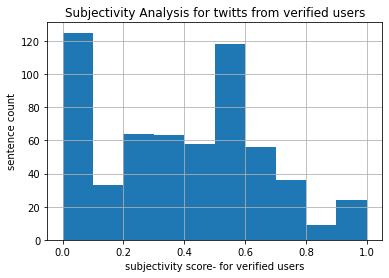

In [97]:
plt.hist(total_data[total_data['verified'] == True]['subjectivity'], bins=10) #, normed=1, alpha=0.75)
plt.title("Subjectivity Analysis for twitts from verified users")
plt.xlabel('subjectivity score- for verified users')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('subjectivity-verified.pdf')
plt.show()

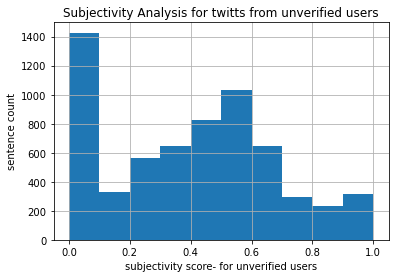

In [98]:
plt.hist(total_data[total_data['verified'] == False]['subjectivity'], bins=10) #, normed=1, alpha=0.75)
plt.title("Subjectivity Analysis for twitts from unverified users")
plt.xlabel('subjectivity score- for unverified users')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('subjectivity-unverified.pdf')
plt.show()

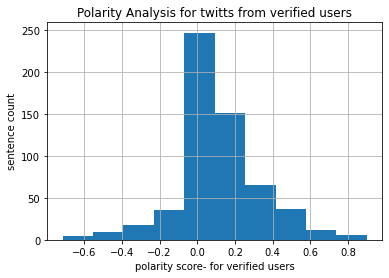

In [99]:
plt.hist(total_data[total_data['verified'] == True]['polarity'], bins=10) #, normed=1, alpha=0.75)
plt.title("Polarity Analysis for twitts from verified users")
plt.xlabel('polarity score- for verified users')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('polarity-verified.pdf')
plt.show()

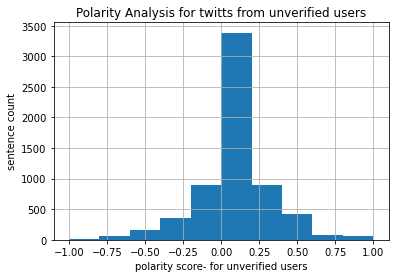

In [100]:
plt.hist(total_data[total_data['verified'] == False]['polarity'], bins=10) #, normed=1, alpha=0.75)
plt.title("Polarity Analysis for twitts from unverified users")
plt.xlabel('polarity score- for unverified users')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('polarity-unverified.pdf')
plt.show()

### Sentiment per source

In [101]:
top_3_sources = ['Twitter Web App', 'Twitter for iPhone', 'Twitter for Android']
total_data[total_data['source'].isin(top_3_sources)].groupby('source')['polarity', 'subjectivity'].mean()

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/626040182.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_data[total_data['source'].isin(top_3_sources)].groupby('source')['polarity', 'subjectivity'].mean()


,polarity,subjectivity
source,,
Twitter Web App,0.081593,0.410647
Twitter for Android,0.050650,0.385789
Twitter for iPhone,0.057667,0.393964


##### 

### Verifying our sentiment analysis with the 'possible_sensitivity' assignment from Twitter 

In [102]:
total_data.groupby('possibly_sensitive')['polarity', 'subjectivity'].mean()

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/3440778779.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_data.groupby('possibly_sensitive')['polarity', 'subjectivity'].mean()


,polarity,subjectivity
possibly_sensitive,,
False,0.067870,0.390786
True,-0.002533,0.313319


##### We see that it check out that what Twitter thinks as possibly sensitive also shows up in our analysis as we have a negative polarity score on an average for those tweets

#### 

### Analyzing influence scores for authors and tweets for verified and unverified users

In [103]:
total_data.groupby('verified')['influence_score', 'influence_author'].mean()

/var/folders/4q/wcwxv26n0fbby_yfjrgjbjp80000gn/T/ipykernel_81908/602775023.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_data.groupby('verified')['influence_score', 'influence_author'].mean()


,influence_score,influence_author
verified,,
False,4.388660,4.907974e+04
True,67.894198,1.001766e+06


### Additional Analysis

In [104]:
# Just checking top 10
total_data.sort_values('influence_score', ascending = False).head(10)['name']

7314          Nandita Bose
9106           PeterSweden
7040        Caroline Lucas
4925             Tim Young
4350    Liz Churchill ™ 🇨🇦
3856            Dan Rather
6778             FailWhale
7342                   NaN
6965                   NaN
5983     Leonardo DiCaprio
Name: name, dtype: object

### Although the authors with highest influence score are all publications/press but we see that purely based on the tweets' influence score we see no publications but individuals. Also, we see Leonardo actively speaking about climate change. And therefore we think that people can be more influential than press.

In [105]:
# Number of tweets for the most vocal authors
total_data[total_data['author_id'].isin(top_vocal)].groupby('name')['text'].count()

name
Peter Paul             55
Seeking Truth&Facts    72
leave world better     31
Name: text, dtype: int64